In [1]:
Pkg.add("PyPlot")
Pkg.add("DataStructures")
Pkg.add("KrylovMethods")
Pkg.update()

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of PyPlot
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of DataStructures
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of KrylovMethods
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Updating METADATA...
INFO: Computing changes...
INFO: No packages to install, update or remove


In [2]:
include("kernel.jl")

getInversion (generic function with 1 method)

### Double layer problem

The kernel is taken as ``r'*n / (r'*r)``, where ``r = x -y``. And nothing else changes.

In [3]:
k = KIFMM()
N = 4000
M = 4000
source = zeros(N, 2)
θ = 2 * π / N
for i = 1:N
    source[i, 1] = cos(i * θ)
    source[i, 2] = sin(i * θ)
end
# for unit circle
normal = source

target=zeros(M,2)

for j = 1:M
    target[j, 1] = cos(j * θ)
    target[j, 2] = sin(j * θ)
end

# use 1.0 as input, should return 0 outside and 1.0 inside.
charge = ones(N)

### kernel function for double layer
function g(s, n, t)
    r =  s-t
    if (norm(r) < 1e-14)
        return 0.
    else
        return dot(r,n)/dot(r,r)
    end
end

g (generic function with 1 method)

### Initialize the kernel struct

In [4]:
@time initialize!(k, 24, source, normal, target, charge, N, M, 40, 10, g);

  1.575231 seconds (3.03 M allocations: 109.555 MB, 2.20% gc time)


### Run FMM

In [5]:
@time potential = FMM!(k);

  4.113438 seconds (26.30 M allocations: 838.431 MB, 3.16% gc time)


### Relative error

In [6]:
tic()
checkPotential = zeros(M)
for i = 1:M
    for j = 1:N
        checkPotential[i] += k.kernel(k.tree.sourceTree[j,:], k.tree.normalTree[j,:], k.tree.targetTree[i,:])* k.chargeTree[j]
    end
end
toc()
norm(potential - checkPotential)/norm(checkPotential)

elapsed time: 16.313541431 seconds


0.002615092516301373

### display

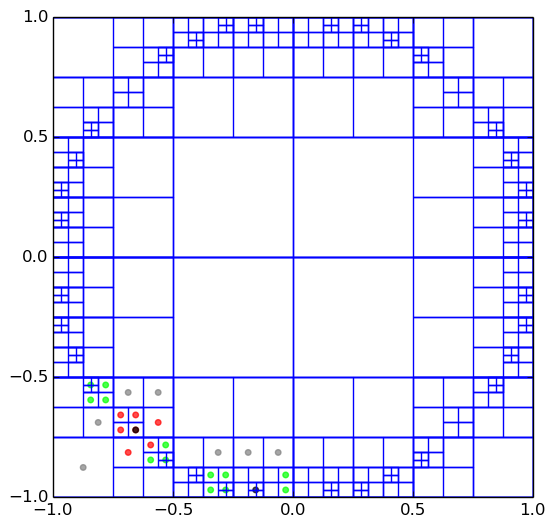

In [13]:
display(k.tree, [75, 43]);

### GMRES

In [8]:
using KrylovMethods

In [9]:
function A(x)
    initialize!(k, 24, source, normal, target, x, N, M, 40, 10, g);
    return 0.5 * x + FMM!(k)/N
end
    

A (generic function with 1 method)

In [10]:
testCharge = rand(N)
@time y = gmres(A, testCharge, 30,tol=1e-12);

 13.231484 seconds (134.43 M allocations: 4.153 GB, 5.90% gc time)


### Convergence rate of GMRES

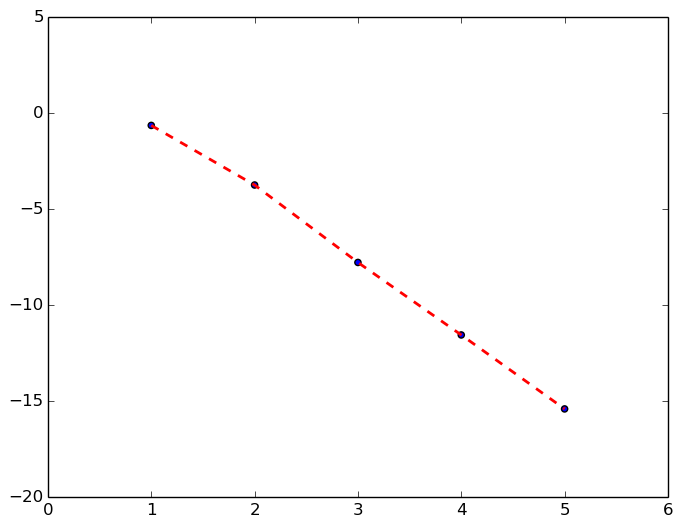

In [12]:
plot(1:5, log10(y[5]),"b",color="red", linewidth=2.0, linestyle="--");scatter(1:5, log10(y[5]));